# **Anti-Money Laundering Detector**

## **Loading the libraries**

In [1]:
import os
import json
import zipfile
from pyspark.sql import SparkSession
import random
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, when, count, avg, to_timestamp, hour, dayofweek
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql import Window
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

## **Loading the dataset**

According to the dataset owner, the data is divided in 6 datasets into two groups of three:

* Group HI has a relatively higher illicit ratio (more laundering).
* Group LI has a relatively lower illicit ratio (less laundering).

Both HI and LI internally have three sets of data: small, medium, and large. Also, provides two files for each of the six datasets:

* A list of transactions in CSV format
* A text file list of laundering transactions.

So, we have a larga dataset, but for our project, we will use the following files:

* HI-Medium_Trans.csv
* HI-Medium_Patterns.txt
* LI-Medium_Trans.csv
* LI-Medium_Patterns.txt

Transaction files and Pattern files, each they will be merged in a single DataFrame.

In [2]:
# Using Kaggle API to download the dataset. 
# Generate the kaggle.json from Settings > API > Create new token in Kaggle user profile. Paste it in /user/.kaggle/ folder
api = KaggleApi()
api.authenticate()

# Downloading the dataset from Kaggle
files = [
    ('ealtman2019/ibm-transactions-for-anti-money-laundering-aml', 'HI-Medium_Trans.csv'),
    ('ealtman2019/ibm-transactions-for-anti-money-laundering-aml', 'HI-Medium_Patterns.txt'),
    ('ealtman2019/ibm-transactions-for-anti-money-laundering-aml', 'LI-Medium_Trans.csv'),
    ('ealtman2019/ibm-transactions-for-anti-money-laundering-aml', 'LI-Medium_Patterns.txt'),
]

# Unzip the files (if zip extension)
for dataset, file_name in files:
    api.dataset_download_file(dataset, file_name=file_name, path='./dataset/')
    zip_path = f'./dataset/{file_name}.zip'
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('./dataset/')
        os.remove(zip_path)

Dataset URL: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
Dataset URL: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
Dataset URL: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
Dataset URL: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml


In [3]:
# Creating a SparkSession to manipulate the datasets
spark = SparkSession.builder \
    .appName("AML_Detection") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

### **Transactions Dataset**

In [4]:
# Define schema for the transactions
schema = StructType([
    StructField("Timestamp", StringType(), True),
    StructField("From_Bank", StringType(), True),
    StructField("From_Account", StringType(), True),
    StructField("To_Bank", StringType(), True),
    StructField("To_Account", StringType(), True),
    StructField("Amount_Received", FloatType(), True),
    StructField("Receiving_Currency", StringType(), True),
    StructField("Amount_Paid", FloatType(), True),
    StructField("Payment_Currency", StringType(), True),
    StructField("Payment_Format", StringType(), True)
])

### High Ilicit - Medium

In [5]:
# Read the CSV file into a Spark DataFrame
hi_medium_df = spark.read.csv("./dataset/HI-Medium_Trans.csv", schema=schema, header=True)

# Display the first few rows of the DataFrame
hi_medium_df.show()

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+
|       Timestamp|From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+
|2022/09/01 00:17|      020|   800104D70|    020| 800104D70|        6794.63|         US Dollar|    6794.63|       US Dollar|  Reinvestment|
|2022/09/01 00:02|    03196|   800107150|  03196| 800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|
|2022/09/01 00:17|    01208|   80010E430|  01208| 80010E430|        1880.23|         US Dollar|    1880.23|       US Dollar|  Reinvestment|
|2022/09/01 00:03|    01208|   80010E650|    020| 80010E6F0|     7.396688E7|         US Dollar| 7.396688E7|       US Dollar|        Cheque|
|2022/09/01 00:02|  

### Low Ilicit - Medium

In [6]:
# Read the CSV file into a Spark DataFrame
li_medium_df = spark.read.csv("./dataset/LI-Medium_Trans.csv", schema=schema, header=True)

# Display the first few rows of the DataFrame
li_medium_df.show()

+----------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+
|       Timestamp|From_Bank|From_Account| To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|
+----------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+
|2022/09/01 00:15|      020|   800104D70|     020| 800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|
|2022/09/01 00:18|    03196|   800107150|   03196| 800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|
|2022/09/01 00:23|    01208|   80010E430|   01208| 80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|
|2022/09/01 00:19|    03203|   80010EA80|   03203| 80010EA80|       13284.41|         US Dollar|   13284.41|       US Dollar|  Reinvestment|
|2022/09/01 0

In [7]:
# Combine both datasets
trans_df = hi_medium_df.union(li_medium_df)

### **Patterns Dataset**

### High Ilicit - Medium

In [8]:
# Read the file into a Spark DataFrame
hi_patterns_df = spark.read.text("./dataset/HI-Medium_Patterns.txt")

# Display the first few rows of the DataFrame
hi_patterns_df.show()

+--------------------+
|               value|
+--------------------+
|BEGIN LAUNDERING ...|
|2022/09/01 05:14,...|
|2022/09/03 13:09,...|
|2022/09/01 07:40,...|
|2022/09/01 14:19,...|
|2022/09/02 12:40,...|
|2022/09/03 06:34,...|
|END LAUNDERING AT...|
|                    |
|BEGIN LAUNDERING ...|
|2022/09/01 00:19,...|
|2022/09/01 19:35,...|
|2022/09/02 02:58,...|
|2022/09/02 18:02,...|
|2022/09/03 07:16,...|
|2022/09/03 11:39,...|
|2022/09/03 12:04,...|
|2022/09/04 07:27,...|
|2022/09/04 08:38,...|
|2022/09/05 13:23,...|
+--------------------+
only showing top 20 rows



### Low Ilicit - Medium

In [9]:
# Read the file into a Spark DataFrame
li_patterns_df = spark.read.text("./dataset/LI-Medium_Patterns.txt")

# Display the first few rows of the DataFrame
li_patterns_df.show()

+--------------------+
|               value|
+--------------------+
|BEGIN LAUNDERING ...|
|2022/09/01 00:29,...|
|2022/09/04 12:49,...|
|2022/09/01 12:28,...|
|2022/09/04 13:39,...|
|2022/09/01 14:26,...|
|2022/09/04 15:34,...|
|2022/09/02 15:52,...|
|2022/09/04 16:27,...|
|2022/09/02 17:41,...|
|2022/09/05 08:36,...|
|2022/09/03 08:04,...|
|2022/09/05 13:36,...|
|2022/09/03 15:18,...|
|2022/09/05 15:45,...|
|2022/09/03 16:50,...|
|2022/09/05 16:00,...|
|2022/09/03 22:43,...|
|2022/09/05 17:50,...|
|2022/09/03 23:22,...|
+--------------------+
only showing top 20 rows



In [10]:
# Combine both datasets
patterns_df = hi_patterns_df.union(li_patterns_df)

## **PreProcessing**

### Identify Laundering Patterns:
Each laundering attempt begins with BEGIN LAUNDERING ATTEMPT - [PATTERN] and ends with END LAUNDERING ATTEMPT.

Used regex to extract pattern types and transaction details.

In [11]:
# Step 1: Extract Pattern_Type where there is "BEGIN LAUNDERING ATTEMPT"
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.when(F.col("value").rlike("BEGIN LAUNDERING ATTEMPT - (.+)"),
           F.regexp_extract(F.col("value"), "BEGIN LAUNDERING ATTEMPT - (.+)", 1))
     .otherwise(None)
)

# Step 2: Forward fill the Pattern_Type to propagate it down until "END LAUNDERING ATTEMPT"
window_spec = Window.orderBy(F.monotonically_increasing_id()).rowsBetween(Window.unboundedPreceding, 0)
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.last("Pattern_Type", True).over(window_spec)
)

# Step 3: Filter out rows with "END LAUNDERING ATTEMPT" as they only mark the end of an attempt
patterns_df = patterns_df.filter(~F.col("value").contains("END LAUNDERING ATTEMPT"))

In [12]:
# Show the DataFrame without truncating long strings
patterns_df.show(truncate=False)

+------------------------------------------------------------------------------------------------+-------------------+
|value                                                                                           |Pattern_Type       |
+------------------------------------------------------------------------------------------------+-------------------+
|BEGIN LAUNDERING ATTEMPT - STACK                                                                |STACK              |
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK              |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK              |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK              |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK              |
|2022/09/02 12:40,0024750,81363F410,0213834,8087

In [13]:
from pyspark.sql import functions as F

# Remove any text after the colon in Pattern_Type if it exists
patterns_df = patterns_df.withColumn(
    "Pattern_Type",
    F.regexp_replace(F.col("Pattern_Type"), ":.*", "")
)

# Display the DataFrame (use .show() in local PySpark)
patterns_df.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+
|value                                                                                           |Pattern_Type|
+------------------------------------------------------------------------------------------------+------------+
|BEGIN LAUNDERING ATTEMPT - STACK                                                                |STACK       |
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK       |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK       |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK       |
|2022/09/02 12:40,0024750,81363F410,0213834,808757B00,16898.29,US Dollar,16898.29,US Dollar,ACH,1|STACK 

In [14]:
# Filter to get only transaction lines and ignore start/end laundering attempt lines
laundering_transactions = patterns_df.filter(patterns_df.value.rlike(r'\d{4}/\d{2}/\d{2}'))

# Unpersist patterns_df to free memory
patterns_df.unpersist()

# Cache laundering_transactions for reuse
laundering_transactions.cache()

# Display the filtered DataFrame (use .show() instead of display())
laundering_transactions.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+
|value                                                                                           |Pattern_Type|
+------------------------------------------------------------------------------------------------+------------+
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |
|2022/09/03 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1   |STACK       |
|2022/09/01 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1   |STACK       |
|2022/09/01 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1   |STACK       |
|2022/09/02 12:40,0024750,81363F410,0213834,808757B00,16898.29,US Dollar,16898.29,US Dollar,ACH,1|STACK       |
|2022/09/03 06:34,0213834,808757B00,000,800073EF0,17607.19,US Dollar,17607.19,US Dollar,ACH,1    |STACK 

In [15]:
# Updated Code for Better Readability
columns = [
    "Timestamp", "From_Bank", "From_Account", "To_Bank", "To_Account",
    "Amount_Received", "Receiving_currency", "Amount_paid",
    "Payment_currency", "Payment_Format", "isLaundering"
]

for idx, col_name in enumerate(columns):
    laundering_transactions = laundering_transactions.withColumn(col_name, F.split(F.col("value"), ",").getItem(idx))

In [16]:
# Display the results
laundering_transactions.show(truncate=False)

+------------------------------------------------------------------------------------------------+------------+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+
|value                                                                                           |Pattern_Type|Timestamp       |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_currency|Amount_paid|Payment_currency|Payment_Format|isLaundering|
+------------------------------------------------------------------------------------------------+------------+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+
|2022/09/01 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    |STACK       |2022/09/01 05:14|00952    |8139F54E0   |0111632|8062C56E0 |5331.44        |US Dollar         |5331.4

In [17]:
laundering_transactions = laundering_transactions.select("Timestamp", "From_Bank", "Pattern_Type", "isLaundering")

#  Display the results
laundering_transactions.show(truncate=False)

+----------------+---------+------------+------------+
|Timestamp       |From_Bank|Pattern_Type|isLaundering|
+----------------+---------+------------+------------+
|2022/09/01 05:14|00952    |STACK       |1           |
|2022/09/03 13:09|0111632  |STACK       |1           |
|2022/09/01 07:40|0118693  |STACK       |1           |
|2022/09/01 14:19|013729   |STACK       |1           |
|2022/09/02 12:40|0024750  |STACK       |1           |
|2022/09/03 06:34|0213834  |STACK       |1           |
|2022/09/01 00:19|0134266  |CYCLE       |1           |
|2022/09/01 19:35|0036925  |CYCLE       |1           |
|2022/09/02 02:58|0119211  |CYCLE       |1           |
|2022/09/02 18:02|0132965  |CYCLE       |1           |
|2022/09/03 07:16|0137089  |CYCLE       |1           |
|2022/09/03 11:39|0216618  |CYCLE       |1           |
|2022/09/03 12:04|0024083  |CYCLE       |1           |
|2022/09/04 07:27|0038110  |CYCLE       |1           |
|2022/09/04 08:38|0225015  |CYCLE       |1           |
|2022/09/0

In [18]:
# Count empty strings in each column
empty_string_counts = laundering_transactions.select(
    [sum(when(col(c) == "", 1).otherwise(0)).alias(c) for c in laundering_transactions.columns])

# Show the result
empty_string_counts.show(truncate=False)

+---------+---------+------------+------------+
|Timestamp|From_Bank|Pattern_Type|isLaundering|
+---------+---------+------------+------------+
|0        |0        |0           |0           |
+---------+---------+------------+------------+



In [19]:
laundering_transactions.createOrReplaceTempView("combined")

In [20]:
# Query using spark.sql()
result_df = spark.sql("""
    SELECT Pattern_Type, COUNT(Pattern_Type) AS count
    FROM combined
    GROUP BY Pattern_Type
""")

# Show the result
result_df.show(truncate=False)

+--------------+-----+
|Pattern_Type  |count|
+--------------+-----+
|STACK         |4601 |
|CYCLE         |2518 |
|FAN-IN        |2644 |
|GATHER-SCATTER|4830 |
|BIPARTITE     |2623 |
|FAN-OUT       |2617 |
|SCATTER-GATHER|4874 |
|RANDOM        |1945 |
+--------------+-----+



In [21]:
laundering_transactions.cache().groupBy("isLaundering").count().show()

+------------+-----+
|isLaundering|count|
+------------+-----+
|           1|26652|
+------------+-----+



### **Laundering Transactions Labeling**

Joined the laundering pattern DataFrame (laundering_transactions) with the combined transaction DataFrame (trans_df) on transaction identifiers.

In [22]:
# Join the DataFrames on Timestamp, From_Bank, and To_Bank
joined_df = trans_df.join(
    laundering_transactions,
    on=["Timestamp", "From_Bank"],
    how="left"
)

# Freeing from cache
trans_df.unpersist()
laundering_transactions.unpersist()

DataFrame[Timestamp: string, From_Bank: string, Pattern_Type: string, isLaundering: string]

In [23]:
# Fill null values in the `isLaundering` column with 0
joined_df = joined_df.withColumn(
    "isLaundering",
    F.when(F.col("isLaundering").isNull(), F.lit(0)).otherwise(F.col("isLaundering"))
)

In [24]:
# Cache the joined DataFrame
joined_df.cache()

# Display the cached DataFrame (use .show() instead of .display())
joined_df.show(truncate=False)

+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|Timestamp       |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|
+----------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|2022/09/01 00:17|020      |800104D70   |020    |800104D70 |6794.63        |US Dollar         |6794.63    |US Dollar       |Reinvestment  |NULL        |0           |
|2022/09/01 00:02|03196    |800107150   |03196  |800107150 |7739.29        |US Dollar         |7739.29    |US Dollar       |Reinvestment  |NULL        |0           |
|2022/09/01 00:17|01208    |80010E430   |01208  |80010E430 |1880.23        |US Dollar         |1880.23    |US Dollar       |Reinvestment  |NULL        |0           |
|202

In [25]:
# Convert 'isLaundering' from string to integer
joined_df = joined_df.withColumn("isLaundering", col("isLaundering").cast("integer"))


# Verify the schema change
joined_df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From_Bank: string (nullable = true)
 |-- From_Account: string (nullable = true)
 |-- To_Bank: string (nullable = true)
 |-- To_Account: string (nullable = true)
 |-- Amount_Received: float (nullable = true)
 |-- Receiving_Currency: string (nullable = true)
 |-- Amount_Paid: float (nullable = true)
 |-- Payment_Currency: string (nullable = true)
 |-- Payment_Format: string (nullable = true)
 |-- Pattern_Type: string (nullable = true)
 |-- isLaundering: integer (nullable = true)



In [26]:
joined_df.groupBy("isLaundering").count().show()

+------------+--------+
|isLaundering|   count|
+------------+--------+
|           1|   84928|
|           0|63065007|
+------------+--------+



The dataset is imbalanced.

### Balance the data

In [27]:
# Register joined_df as a temporary view to use SQL
joined_df.createOrReplaceTempView("joined_table")

# Step 1: Identify rows to drop
# Here we assign a random value to each row that meets the condition, then select 50% of those rows
query = """
SELECT *
FROM joined_table
WHERE NOT ((Pattern_Type IS NULL) AND (isLaundering = 0) AND (rand() < 0.5))
"""

# Execute the SQL query
balanced_df = spark.sql(query)

In [28]:
joined_df.unpersist()

DataFrame[Timestamp: string, From_Bank: string, From_Account: string, To_Bank: string, To_Account: string, Amount_Received: float, Receiving_Currency: string, Amount_Paid: float, Payment_Currency: string, Payment_Format: string, Pattern_Type: string, isLaundering: int]

In [29]:
balanced_df.cache().groupBy("isLaundering").count().show()

+------------+--------+
|isLaundering|   count|
+------------+--------+
|           1|   84928|
|           0|31535818|
+------------+--------+



### Data Cleaning and Exploration

In [30]:
# Count NULL values in each column
null_counts = balanced_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in balanced_df.columns])

# Show the result
null_counts.show()

+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|Timestamp|From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+
|        0|        0|           0|      0|         0|              0|                 0|          0|               0|             0|    31535818|           0|
+---------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+



In [31]:
balanced_df = balanced_df.na.fill({
    "Pattern_Type": "Unknown"
})

In [32]:
balanced_df = balanced_df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm")) \
                         .withColumn("Hour", hour("Timestamp")) \
                         .withColumn("DayOfWeek", dayofweek("Timestamp"))

In [33]:
# Show the final DataFrame
balanced_df.show(truncate=False)

+-------------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+
|Timestamp          |From_Bank|From_Account|To_Bank |To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|
+-------------------+---------+------------+--------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+
|2022-09-01 00:03:00|01208    |80010E650   |020     |80010E6F0 |7.396688E7     |US Dollar         |7.396688E7 |US Dollar       |Cheque        |Unknown     |0           |0   |5        |
|2022-09-01 00:09:00|011      |80010E600   |011     |80010E600 |16.33          |US Dollar         |16.33      |US Dollar       |Reinvestment  |Unknown     |0           |0   |5        |
|2022-09-01 00:06:00|01208    |80010E650   |01208   |80010E650 |4.86       

## **Feature Engineering**
Calculate FanOut, FanIn, and AvgAmountSent.

-FanOut:
how many different transactions it initiates.

-FanIn:
how many different transactions it receives.

-AvgAmountSent:
the typical transaction size for each account as a sender.

In [34]:
# Window specifications
sender_window = Window.partitionBy("From_Account")
receiver_window = Window.partitionBy("To_Account")

# Calculate fan-out, fan-in, and average amount sent
featured_df = balanced_df.withColumn("FanOut", count("To_Account").over(sender_window)) \
                         .withColumn("FanIn", count("From_Account").over(receiver_window)) \
                         .withColumn("AvgAmountSent", avg("Amount_Paid").over(sender_window))

In [35]:
balanced_df.unpersist()

# Show the resulting DataFrame
featured_df.show(truncate=False)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+-----------------+
|Timestamp          |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|FanOut|FanIn|AvgAmountSent    |
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+-----------------+
|2022-09-01 05:21:00|004      |800060A20   |004    |800060A20 |1834.72        |Rupee             |1834.72    |Rupee           |Reinvestment  |Unknown     |0           |5   |5        |248   |47   |343727.0264566483|
|2022-09-05 19:53:00|004      |800060A20   |004    |800060A20 |3117.27        |Euro              |268273.75  |Rupee           |ACH          

### Encode Categorical Variables

Converted categorical columns into numerical indices using StringIndexer.

In [36]:
currency_index = StringIndexer(inputCol="Receiving_Currency", outputCol="CurrencyIndex")
payment_format_index = StringIndexer(inputCol="Payment_Format", outputCol="PaymentFormatIndex")
pattern_type_index = StringIndexer(inputCol="Pattern_Type", outputCol="PatternTypeIndex")

featured_df = currency_index.fit(featured_df).transform(featured_df)
featured_df = payment_format_index.fit(featured_df).transform(featured_df)
featured_df = pattern_type_index.fit(featured_df).transform(featured_df)

In [37]:
# Show the resulting DataFrame
featured_df.show(truncate=False)

+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+-----------------+-------------+------------------+----------------+
|Timestamp          |From_Bank|From_Account|To_Bank|To_Account|Amount_Received|Receiving_Currency|Amount_Paid|Payment_Currency|Payment_Format|Pattern_Type|isLaundering|Hour|DayOfWeek|FanOut|FanIn|AvgAmountSent    |CurrencyIndex|PaymentFormatIndex|PatternTypeIndex|
+-------------------+---------+------------+-------+----------+---------------+------------------+-----------+----------------+--------------+------------+------------+----+---------+------+-----+-----------------+-------------+------------------+----------------+
|2022-09-01 05:21:00|004      |800060A20   |004    |800060A20 |1834.72        |Rupee             |1834.72    |Rupee           |Reinvestment  |Unknown     |0           |5   |5        |248   |47   |343727.02

### Generate synthetic data for minority, using SMOTE

In [38]:
# Step 1: Select only the required columns (excluding 'isLaundering')
feature_columns = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent",
                   "Hour", "DayOfWeek", "CurrencyIndex",
                   "PaymentFormatIndex", "PatternTypeIndex"]

# Select features for minority class (isLaundering = 1)
minority_df = featured_df.filter(F.col("isLaundering") == 1).select(*feature_columns)
majority_df = featured_df.filter(F.col("isLaundering") == 0).select(*feature_columns, "isLaundering")

featured_df.unpersist()

# Step 2: Define a function to generate synthetic samples (excluding isLaundering)
def generate_synthetic_samples(minority_data, num_samples=10):
    synthetic_samples = []

    for row in minority_data:
        base_vector = np.array([row[col] for col in feature_columns])

        # Find random neighbors within the minority class
        neighbors = random.sample(minority_data, k=num_samples)
        for neighbor in neighbors:
            neighbor_vector = np.array([neighbor[col] for col in feature_columns])

            # Interpolate to create a synthetic sample
            gap = np.random.rand()
            synthetic_vector = base_vector + gap * (neighbor_vector - base_vector)

            # Append the synthetic sample without the 'isLaundering' column
            synthetic_samples.append(tuple(synthetic_vector.tolist()))

    return synthetic_samples

# Step 3: Collect minority samples and generate synthetic samples
minority_data = minority_df.collect()
synthetic_samples = generate_synthetic_samples(minority_data, num_samples=50)

# Step 4: Define schema for synthetic samples without 'isLaundering'
schema = StructType([StructField(col, DoubleType(), True) for col in feature_columns])

# Create synthetic DataFrame from synthetic samples
synthetic_df = spark.createDataFrame(synthetic_samples, schema=schema)

# Step 5: Add 'isLaundering' column with value 1 to synthetic samples
synthetic_df = synthetic_df.withColumn("isLaundering", F.lit(1))

# Step 6: Combine the majority and synthetic DataFrames
balanced_featured_df = majority_df.union(synthetic_df)

# Display counts to confirm balancing
balanced_featured_df.cache().groupBy("isLaundering").count().show()

+------------+--------+
|isLaundering|   count|
+------------+--------+
|           0|31535818|
|           1| 4246400|
+------------+--------+



In [39]:
# Cache the joined DataFrame
balanced_featured_df.cache()

# Display the cached DataFrame
balanced_featured_df.show(truncate=False) 

+-----------------+------+-----+-----------------+----+---------+-------------+------------------+----------------+------------+
|Amount_Received  |FanOut|FanIn|AvgAmountSent    |Hour|DayOfWeek|CurrencyIndex|PaymentFormatIndex|PatternTypeIndex|isLaundering|
+-----------------+------+-----+-----------------+----+---------+-------------+------------------+----------------+------------+
|1834.719970703125|248.0 |47.0 |343727.0264566483|5.0 |5.0      |5.0          |4.0               |0.0             |0           |
|1.4794535E7      |248.0 |21.0 |343727.0264566483|18.0|6.0      |5.0          |0.0               |0.0             |0           |
|21381.1796875    |248.0 |47.0 |343727.0264566483|7.0 |2.0      |5.0          |0.0               |0.0             |0           |
|8330752.0        |248.0 |21.0 |343727.0264566483|18.0|6.0      |5.0          |5.0               |0.0             |0           |
|10683.91015625   |248.0 |47.0 |343727.0264566483|7.0 |2.0      |5.0          |1.0               

In [40]:
balanced_featured_df.groupBy("isLaundering").count().show(truncate=False)

+------------+--------+
|isLaundering|count   |
+------------+--------+
|0           |31535818|
|1           |4246400 |
+------------+--------+



### Assemble Features into a Vector

Use VectorAssembler to create a feature vector for model input

In [41]:
features_col = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent", "Hour", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex"]
correlation_features = ["Amount_Received", "FanOut", "FanIn", "AvgAmountSent", "Hour", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex", "isLaundering"]
assembler = VectorAssembler(inputCols=correlation_features, outputCol="corr_features")
df_vector = assembler.transform(balanced_featured_df)

### Correlation heatmap

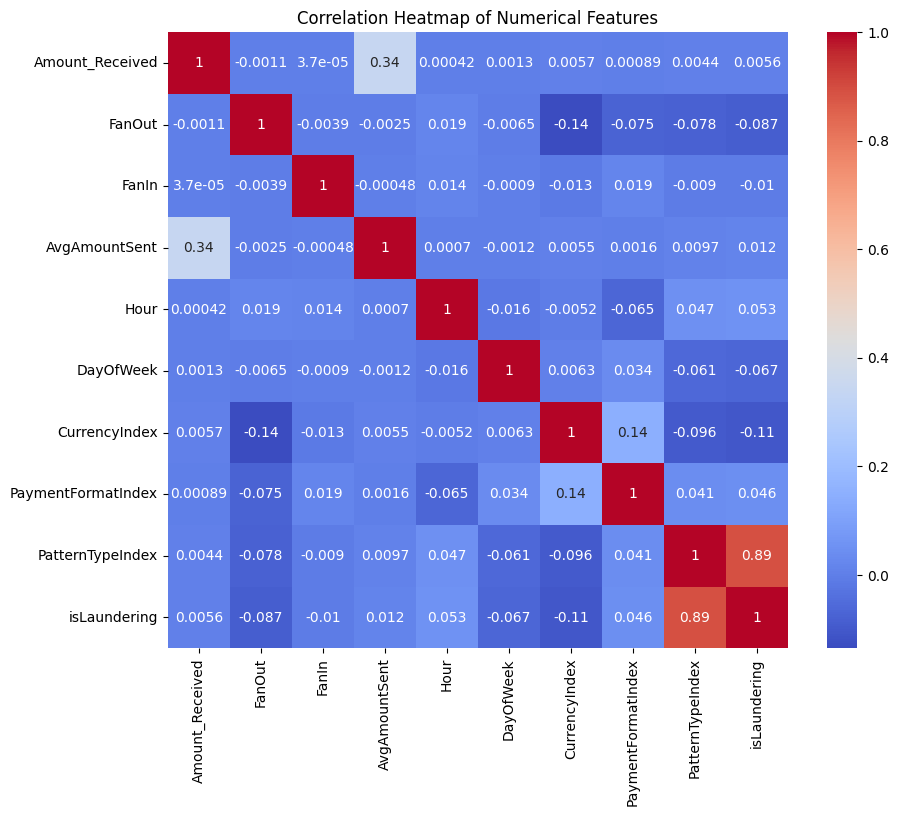

In [42]:
# Calculate correlation matrix
correlation_matrix = Correlation.corr(df_vector, "corr_features").head()[0].toArray()

# Convert to a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, xticklabels=correlation_features, yticklabels=correlation_features, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Observations:

#### Correlation Heatmap:
Amount_Received and AvgAmountSent show a moderately positive correlation (0.34). Including both might introduce some redundancy, but they may still capture distinct aspects of the data.

Other features have relatively low correlations with each other, which generally indicates that they might add unique information to the model.

- PatternTypeIndex Has the strongest positive correlation with
isLaundering (0.89).
- CurrencyIndex Shows a weak positive correlation (0.046) with isLaundering.
- PaymentFormatIndex Also shows a weak positive correlation (0.053) with isLaundering.
- FanOut and DayOfWeek Show negative correlations (-0.087 and -0.067, respectively) with isLaundering.
- Hour and AvgAmountSent Show weak positive correlations (0.014 and 0.053, respectively) with isLaundering.
- Amount_Received Has an extremely weak positive correlation (0.0059) with isLaundering, suggesting it's nearly uncorrelated.
- FanIn Has a weak negative correlation (-0.01) with isLaundering.

#### Key Takeaways:
- PatternTypeIndex is the standout feature, showing a strong correlation with isLaundering. It’s critical to include this in the model.
- Features like CurrencyIndex and PaymentFormatIndex have weak correlations but could still contribute useful information when combined with others.
- Features like Amount_Received, FanIn, and Hour have very weak correlations, and their inclusion should be carefully considered to avoid adding noise to the model.




## **Feature Selection**

In [43]:
# Define all features for the final assembler, using scaled and unscaled features
all_features = [ "FanOut", "AvgAmountSent", "DayOfWeek", "CurrencyIndex", "PaymentFormatIndex", "PatternTypeIndex"]

# Assemble the final feature vector for prediction
assembler_final = VectorAssembler(inputCols=all_features, outputCol="features")
balanced_featured_df = balanced_featured_df.select(all_features + ["isLaundering"])

In [44]:
size_in_memory_gb = balanced_featured_df.rdd.map(lambda row: len(str(row))).sum() / (1024 * 1024 * 1024)
print(f"Approximate size in memory: ({size_in_memory_gb:.2f} GB)")

Approximate size in memory: (5.08 GB)


### Split the data

In [45]:
train_df, val_df, test_df = balanced_featured_df.randomSplit([0.6, 0.2, 0.2], seed=42)
balanced_featured_df.unpersist()
train_df.cache()
val_df.cache()
test_df.cache()

DataFrame[FanOut: double, AvgAmountSent: double, DayOfWeek: double, CurrencyIndex: double, PaymentFormatIndex: double, PatternTypeIndex: double, isLaundering: int]

## **Model Training**

### Created a Pipeline with Random Forest Classifier ML model:

Defined a pipeline to streamline the feature transformations and model training process.

In [46]:
rf = RandomForestClassifier(featuresCol="features", labelCol="isLaundering", numTrees=20, maxDepth=10)
pipeline = Pipeline(stages=[ assembler_final, rf])

### Hyperparameter Tuning using CrossValidator:

- Used CrossValidator to find the best hyperparameters for the Random Forest model.
- BinaryClassificationEvaluator Used to evaluate the model's performance.
- areaUnderROC is a common metric for binary classification, especially useful for imbalanced datasets.

In [47]:
paramGridSearch = ParamGridBuilder().addGrid(rf.numTrees, [10, 20]).addGrid(rf.maxDepth, [10]).build()
evaluatorr = BinaryClassificationEvaluator(labelCol="isLaundering", metricName="areaUnderROC")
crossvalidation = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGridSearch, evaluator=evaluatorr, numFolds=3)
cvModel = crossvalidation.fit(train_df)

### Evaluate on Validation Data:

Used F1 Score, Area Under ROC metrics to evaluate the model on validation data.

In [48]:
# Evaluate ROC on validation data
predictions = cvModel.transform(val_df)
roc_score = evaluatorr.evaluate(predictions)
print("Area Under ROC Score on validation data:", roc_score)

Area Under ROC Score on validation data: 1.0


In [49]:
# Evaluate F1 Score on validation data
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="isLaundering", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print("F1 Score on validation data:", f1_score)

F1 Score on validation data: 1.0


### Final Testing:

Test the model on the test set to get final performance metrics.

In [50]:
# Evaluate ROC on test data
final_predictions = cvModel.transform(test_df)
test_roc_score = evaluatorr.evaluate(final_predictions)
print("Final ROC Score on test data:", test_roc_score)

Final ROC Score on test data: 1.0


In [51]:
# Evaluate F1 Score on test data
test_f1_score = evaluator_f1.evaluate(final_predictions)
print("Final F1 Score on test data:", test_f1_score)

Final F1 Score on test data: 1.0


In [ ]:
#evaluate percision and recall
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="isLaundering", predictionCol="prediction", metricName="weightedRecall")

precision = precision_evaluator.evaluate(final_predictions)
recall = recall_evaluator.evaluate(final_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

### Observations
Unrealistically Good Performance, can be caused by

#### Data Leakage:
If features or information from the test data inadvertently influenced the training process, the model could appear to perform perfectly. Like Using features directly derived from the target variable. (PatternTypeIndex)